# Project 3 - Ames Housing Dataset Challenge <br>
## Thomas Brewer - BOS

In [112]:
# Import libraries

# Basic
import numpy as np
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.model_selection import cross_val_score, train_test_split

# My own cleaning library
import cleaning_tools as ct

# For reloading my tools, while working on them
from importlib import reload

In [305]:
reload(ct)
data = ct.make_clean()

/home/thomas/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [302]:
data.Fireplace

AttributeError: 'DataFrame' object has no attribute 'Fireplace'

Dtype :  float64
N_null =  114
mean : 1978.7077955601446
median : nan
mode : 2005.0


/home/thomas/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


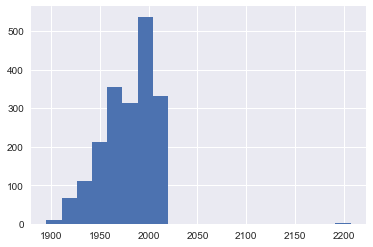

In [306]:
ct.check_values(data, 'Garage_Yr_Blt', cat=False)

In [246]:
data[[c for c in data.columns if 'Central_Air' in c]]

,Central_Air
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


In [42]:
data.Lot_Frontage.isnull().sum()

330

In [43]:
data.shape

(2051, 103)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e33a48a90>]], dtype=object)

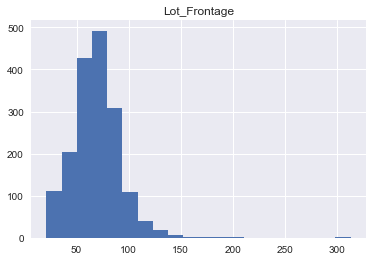

In [45]:
data.hist('Lot_Frontage', bins=20)

In [ ]:
data.

In [220]:
data = ct.make_clean()
cols = [c for c in data.columns if (c == 'SalePrice') or ('Heating' in c)]
corr = data[cols].corr()

print(corr)
#f, ax = plt.subplots(figsize=(15,10))
#sns.heatmap(corr, annot=True, fmt='.2g', ax=ax)

/home/thomas/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


column : Total_Bsmt_SF, strategy : mean, value : 1057.9878048780488
           SalePrice
SalePrice        1.0


In [ ]:
# Setting consistent seed for everything random
seed = 42

In [ ]:
# Functions to load and clean data
# Ultimately useless, but convenient while trying different things.

# Load data
def load_data():
    # Load training data
    train = pd.read_csv('../data/train.csv')

    # Replace spaces with underscores in column names
    train.columns = [c.replace(' ', '_') for c in train.columns]
    return train

# Clean data
# These functions are things I do as I go along.
# I add them here in case I mess something up.  
# Keeps me from having to rerun all the cells.
def make_clean(del_corr=None) :

    # Load data
    train = load_data()
    
    # Make dummy variables for MS_SubClass
    dummies = pd.get_dummies(train.MS_SubClass, prefix='MS_SubClass')
    train = pd.concat([train, dummies])
    train.drop('MS_SubClass', axis=1, inplace=True)
    
    
    # Pool
    # Turn into dummy column has_pool = 0, 1
    # drop Pool_Area, and Pool_QC columns
    train['has_pool'] = train['Pool_Area'].apply(lambda x: 0 if x == 0.0 else 1)
    train.drop(['Pool_Area', 'Pool_QC'], axis=1, inplace=True)
    
    # Fence 
    # Turn into dummy column has_fence = 0, 1
    # drop Fence column    
    train['Fence'].fillna('None', inplace=True)
    train['has_fence'] = train['Fence'].apply(lambda x: 1 if x == 'None' else 0)
    train.drop(['Fence'], axis=1, inplace=True)
    
    # Sale Condition
    # Turn into dummy column for partial sell = 0, 1
    # Drop Sale Condition column
    train['partial_sale'] = train['Sale_Condition'].apply(lambda x: 1 if x == 'Partial' else 0)
    train.drop('Sale_Condition', axis=1, inplace=True)
    
    # Remove any value with correlation to SalePrice less than 0.3 (except ID which we need for later)
    if (del_corr != None):
        for k, v in train.corr()['SalePrice'].items():
            if (abs(v) < del_corr) and (k != 'Id'):
                train.drop(k, axis=1, inplace=True)

    return train

train = load_data()

In [ ]:
print(train.shape)

In [ ]:
ct.dummy_drop(load_data(), 'MS_SubClass', prefix='MS_SubClass')

In [ ]:
%reload_ext cleaning_tools

In [ ]:
dummies = pd.get_dummies(train.MS_SubClass, prefix='MS_SubClass')
train = pd.concat([train, dummies])
train.drop('MS_SubClass', axis=1, inplace=True)

### Preprocessing

In [ ]:
# As a Swimmier, pool caught my attention, so I'll start there :
print(train['Pool_QC'].value_counts())

# Only 9 houses with pool.  I think it might have some effect on SalePrice,
# but I don't think we have enough data to say anything with statistical significance.
# So let's just include a bool column : has_pool, and drop the other Pool related columns. 
# (Probably Won't use it in the end though)
train['has_pool'] = train['Pool_Area'].apply(lambda x: 0 if x == 0.0 else 1)
train.drop(['Pool_Area', 'Pool_QC'], axis=1, inplace=True)

sns.barplot(x='has_pool', y='SalePrice', data=train)

In [ ]:
# Fences : 
train = load_data()
train['Fence'].fillna('None', inplace=True)
print(train['Fence'].value_counts())

f, ax = plt.subplots(figsize=(7, 5))
sns.barplot(x='Fence', y='SalePrice', data=train, ax=ax)
plt.show()

# Seems like most properties don't have a fence, but the spread on it seems low.
# Like for the pool, I'll just make a has_fence column.  May or may not be useful.
train['has_fence'] = train['Fence'].apply(lambda x: 1 if x == 'None' else 0)
train.drop(['Fence'], axis=1, inplace=True)

f, ax = plt.subplots(figsize=(7, 5))
sns.barplot(x='has_fence', y='SalePrice', data=train, ax=ax)
plt.show()

train = make_clean()
train.head()

In [ ]:
train = make_clean()

# Sale Condition
print(train['Sale_Condition'].value_counts())

f, ax = plt.subplots(figsize=(7, 5))
sns.barplot(x='Sale_Condition', y='SalePrice', data=train, ax=ax)
plt.show()

# Seems like PartialSale is what has biggest effect on sale price, make bool col : partial_sale
train['partial_sale'] = train['Sale_Condition'].apply(lambda x: 1 if x == 'Partial' else 0)
train.drop('Sale_Condition', axis=1, inplace=True)

f, ax = plt.subplots(figsize=(7, 5))
sns.barplot(x='partial_sale', y='SalePrice', data=train, ax=ax)
plt.show()

train.head()

## EDA

In [ ]:
train = make_clean()
# Correlation Matrix 
corr = train.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(corr)] = True

f, ax = plt.subplots(figsize=(20,12))
sns.heatmap(corr, mask=mask)

Well there are way too many variables for this to make any sense.  Since we're focusing on SalePrice, right now, let's just show the correlations with that variable.

In [ ]:
# Barplot of feature correlations to SalePrice
train = make_clean()
predictors = [c for c in train.columns if c not in ['SalePrice', 'Id', 'PID']]

corr = train.corr()

f, ax = plt.subplots(figsize=(15,5))
corr.plot(x = corr.columns, y='SalePrice', kind='bar', ax=ax)
ax.set_ylabel('Correlation to Sale Price')
ax.legend()

In [ ]:
# Only look at features with a correlation of abs(0.3) or higher :
train = make_clean(del_corr=0.3)
predictors = [c for c in train.columns if c not in ['SalePrice', 'Id', 'PID']]

corr = train.corr()

f, ax = plt.subplots(figsize=(15,5))
corr.plot(x = corr.columns, y='SalePrice', kind='bar', ax=ax)
ax.set_ylabel('Correlation to Sale Price')
ax.legend()

It got rid of Pool.... =(

We can take a look at some plots with highly correlated features :

In [ ]:
train = make_clean()

f, [(ax1, ax2), (ax3, ax4)] = plt.subplots(nrows=2, ncols=2, figsize=(15,15), sharey=True)
sns.boxplot(x='Overall_Qual', y='SalePrice', data=train, ax=ax1)
sns.regplot(x='Gr_Liv_Area', y='SalePrice', data=train, ax=ax2)
sns.regplot(x='Garage_Area', y='SalePrice', data=train, ax=ax3)
sns.regplot(x='1st_Flr_SF', y='SalePrice', data=train, ax=ax4)

## Picking Features

In [ ]:
def predictors(df):
    p = []
    for k, v in df.corr()['SalePrice'].items():
        if k in ['Id', 'PID', 'SalePrice']:
            print(k)
#         if (k not in ['Id', 'PID', 'SalePrice']):
#             p.append(k) 

    return p

In [ ]:
train = make_clean()
X = train[predictors(train)]
X.head()
y = train['SalePrice'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=0.2)

In [ ]:
train = load_data()
print(train.shape)

train = make_clean()
print(train.shape)

X = train[predictors(train)]
print(X.shape)

print(len(predictors(train)))

There are still a lot of null values.  I need to see which ones have null values specifially and whether or not
they're numerical values.

In [ ]:
for k,v in train.isnull().sum().items():
    if (v != 0):
        print(k, v, type(v))

Well, good news, there are all numeric, so we can apply the same strategy when imputing.  I am not sure what the best strategy is here, so I guess I'll go with **median** for now, and maybe change it later to see if I get better results.  

In [ ]:
X.shape

In [ ]:
imputer = Imputer(strategy='median')
X_imp = imputer.fit_transform(X)
print(type(X_imp))

In [ ]:
len(X.dtypes)

In [ ]:
train = load_data()
train['MS_Zoning']

In [ ]:
data = load_data()
for k, v in data.isnull().sum().items():
    if( v != 0):
        print(k, v, type(v))

In [ ]:
for c in data.columns :
    data.fillna(data[c].mean)

In [ ]:
data